**Install + Load libraries**

In [1]:
! [ -e /content ] && pip install -Uqq fastai --quiet # upgrade fastai on colab 

     |████████████████████████████████| 189 kB 4.1 MB/s 
     |████████████████████████████████| 55 kB 4.5 MB/s 


In [2]:
#export
from fastai.imports import *
from fastai.torch_imports import *
from packaging.version import parse

In [3]:
from fastai.vision.all import *

In [4]:
from fastcore.transform import Pipeline

from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.core import Datasets
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, IntToFloatTensor, Normalize, RandomSplitter, ToTensor, parent_label

from fastai.torch_core import to_device

from fastai.vision.augment import aug_transforms, Resize, RandomResizedCrop, FlipItem
from fastai.vision.data import ImageBlock, PILImage, get_image_files, imagenet_stats

In [5]:
from PIL import Image

In [6]:
!pip install rasterio --quiet

     |████████████████████████████████| 19.3 MB 433 kB/s 


In [7]:
!pip install geopandas --quiet

     |████████████████████████████████| 1.0 MB 3.5 MB/s 
     |████████████████████████████████| 16.7 MB 54.4 MB/s 
     |████████████████████████████████| 6.3 MB 66.6 MB/s 


In [8]:
from typing import Tuple
import rasterio as rio
import geopandas as gpd

In [9]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#Load datasets from Drive
!unzip /content/drive/MyDrive/Datasets/PD/PSCVPR_datasetV.zip

Archive:  /content/drive/MyDrive/Datasets/PD/PSCVPR_datasetV.zip
 extracting: PSCVPR_datasetV/codes.txt  
   creating: PSCVPR_datasetV/labels/
  inflating: PSCVPR_datasetV/labels/osa_10_0.tif  
  inflating: PSCVPR_datasetV/labels/osa_10_1.tif  
  inflating: PSCVPR_datasetV/labels/osa_10_10.tif  
  inflating: PSCVPR_datasetV/labels/osa_10_11.tif  
  inflating: PSCVPR_datasetV/labels/osa_10_15.tif  
  inflating: PSCVPR_datasetV/labels/osa_10_2.tif  
  inflating: PSCVPR_datasetV/labels/osa_10_6.tif  
  inflating: PSCVPR_datasetV/labels/osa_10_8.tif  
  inflating: PSCVPR_datasetV/labels/osa_105_12.tif  
  inflating: PSCVPR_datasetV/labels/osa_106_4.tif  
  inflating: PSCVPR_datasetV/labels/osa_108_12.tif  
  inflating: PSCVPR_datasetV/labels/osa_108_4.tif  
  inflating: PSCVPR_datasetV/labels/osa_109_1.tif  
  inflating: PSCVPR_datasetV/labels/osa_109_10.tif  
  inflating: PSCVPR_datasetV/labels/osa_109_11.tif  
  inflating: PSCVPR_datasetV/labels/osa_109_15.tif  
  inflating: PSCVPR_datas

In [11]:
#Classes for loading multi-channel bands

def open_npy(fn, chans=None):
    im = torch.from_numpy(np.load(str(fn)))
    if chans is not None: im = im[chans]
    return im

def open_geotiff(fn, chans=None):
    with rio.open(str(fn)) as f:
        data = f.read()
        data = data.astype(np.float32)
    im = torch.from_numpy(data)
    if chans is not None: im = im[chans]
    return im

class MultiChannelTensorImage(TensorImage):
    _show_args = ArrayImageBase._show_args
    def show(self, channels=[1], ctx=None, vmin=None, vmax=None, **kwargs):
        "These need refactoring"
        if len(channels) == 3: 
            return show_composite(self, channels=channels, ctx=ctx, vmin=vmin, vmax=vmax,
                                  **{**self._show_args, **kwargs})
        if len(channels) == 2:
            return show_normalized_spectral_index(self, channels=channels, ctx=ctx,
                                                  **{**self._show_args, **kwargs})
        elif len(channels) == 1: 
            return show_single_channel(self, channel=channels[0], ctx=ctx, 
                                       **{**self._show_args, **kwargs})

    @classmethod
    def create(cls, fn, chans=None,  **kwargs) ->None:
        if str(fn).endswith('npy'): return cls(open_npy(fn=fn, chans=chans))
        elif str(fn).endswith('.tif'): return cls(open_geotiff(fn=fn, chans=chans))
        
    def __repr__(self): return f'{self.__class__.__name__} size={"x".join([str(d) for d in self.shape])}'
    
MultiChannelTensorImage.create = Transform(MultiChannelTensorImage.create) 
        
def show_composite(img, channels, ax=None, figsize=(3,3), title=None, scale=True,
                   ctx=None, vmin=None, vmax=None, **kwargs)->plt.Axes:
    "Show three channel composite so that channels correspond to R, G and B"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    r, g, b = channels
    tempim = img.data.cpu().numpy()
    im = np.zeros((tempim.shape[1], tempim.shape[2], 3))
    im[...,0] = tempim[r]
    im[...,1] = tempim[g]
    im[...,2] = tempim[b]
    if scale: im = norm(im, vmin, vmax)
    ax.imshow(im, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_single_channel(img, channel, ax=None, figsize=(3,3), ctx=None, 
                        title=None, **kwargs) -> plt.Axes:
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    tempim = img.data.cpu().numpy()
    ax.imshow(norm(tempim[channel], vmin=tempim[channel].min(), vmax=tempim[channel].max()), **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_normalized_spectral_index(img, channels, ax=None, figsize=(3,3), ctx=None,
                                   title=None, **kwargs) -> plt.Axes:
    "Show normalized spectral index such as NDVI"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    b_0, b_1 = channels
    tempim = img.data.cpu().numpy()
    im = (tempim[b_0] - tempim[b_1])/(tempim[b_0] + tempim[b_1])
    ax.imshow(im, vmin=-1, vmax=1, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax
        
        
def norm(vals, vmin=None, vmax=None):
    """
    For visualization purposes normalize image with `(vals-vmin)/(vmax-vmin), 
    with vals either specified or within 0.01 and 0.99 quantiles of all values
    """
    vmin = ifnone(vmin, np.quantile(vals, 0.01))
    vmax = ifnone(vmax, np.quantile(vals, 0.99))
    return (vals - vmin)/(vmax-vmin)

In [12]:
#visualize a single TIF image
TEST_TIF = '/content/PSCVPR_datasetV/PS4B/osa_105_12.tif'
tif_img = MultiChannelTensorImage.create(TEST_TIF)
tif_img

MultiChannelTensorImage size=4x256x256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


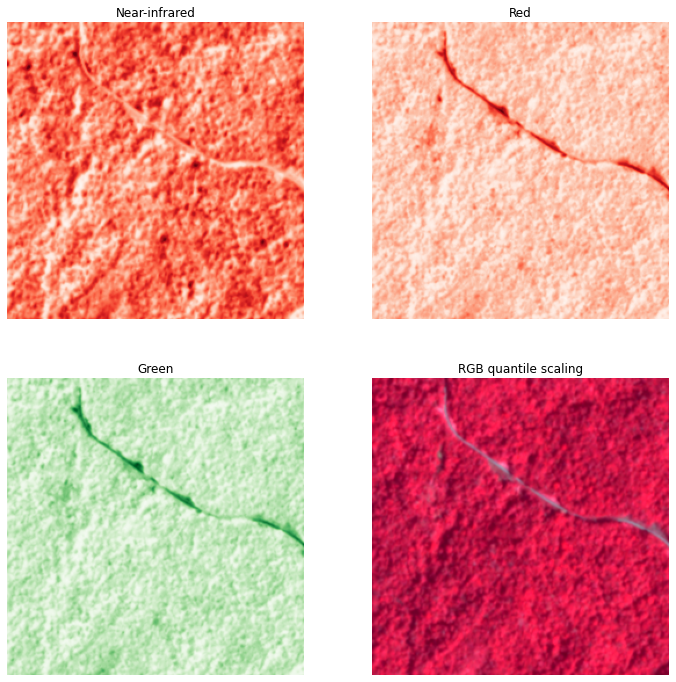

In [13]:
#plot a multichannel image, set the bands you want to visualize
_, ax = plt.subplots(2,2, figsize=(12,12))
tif_img.show(channels=[3], ax=ax[0,0], figsize=(6,6), title='Near-infrared', cmap='Reds')
tif_img.show(channels=[2], ax=ax[0,1], figsize=(6,6), title='Red', cmap='Reds')
tif_img.show(channels=[1], ax=ax[1,0], figsize=(6,6), title='Green', cmap='Greens')
tif_img.show(channels=(3,2,1), ax=ax[1,1], title='RGB quantile scaling', figsize=(6,6), scale=True)
# tif_img.show(channels=(3,2), ax=ax[0,1], title='NDVI', figsize=(6,6), cmap='RdYlGn_r')
# tif_img.show(channels=(3,2,1), ax=ax[1,0], title='RGB manual scaling', figsize=(6,6), scale=True, 
#              vmin=np.array([0,0,0]), vmax=np.array([255,255,255]))
# tif_img.show(channels=(1,2,3), ax=ax[1,1], title='RGB quantile scaling', figsize=(6,6), scale=True)

In [14]:
#define all band datablock
def MultiChannelImageBlock(cls=MultiChannelTensorImage, chans=None): 
    "Default behaviour: use all channels"
    return TransformBlock(partial(cls.create, chans=chans))

In [15]:
#set all band datablock
tif = DataBlock(blocks=(MultiChannelImageBlock()), get_items=partial(get_files, extensions='.tif', recurse=False), splitter=None)

In [16]:
#set paths
path_im = Path('PSCVPR_datasetV/PS4B')
path_lbl = Path('PSCVPR_datasetV/labels')

In [17]:
tif_dls = tif.dataloaders(source=path_im, bs=1)
tif_dls.items

[Path('PSCVPR_datasetV/PS4B/rp_162_8.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_75_13.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_645_9.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_417_10.tif'),
 Path('PSCVPR_datasetV/PS4B/osa_109_9.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_142_1.tif'),
 Path('PSCVPR_datasetV/PS4B/osa_30_2.tif'),
 Path('PSCVPR_datasetV/PS4B/osa_10_15.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_320_14.tif'),
 Path('PSCVPR_datasetV/PS4B/osa_159_2.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_548_0.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_674_14.tif'),
 Path('PSCVPR_datasetV/PS4B/osa_39_10.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_192_14.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_143_6.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_165_4.tif'),
 Path('PSCVPR_datasetV/PS4B/osa_14_8.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_710_2.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_707_6.tif'),
 Path('PSCVPR_datasetV/PS4B/osa_134_9.tif'),
 Path('PSCVPR_datasetV/PS4B/osa_29_12.tif'),
 Path('PSCVPR_datasetV/PS4B/rp_744_11.tif'),
 Path('PSCVPR_dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


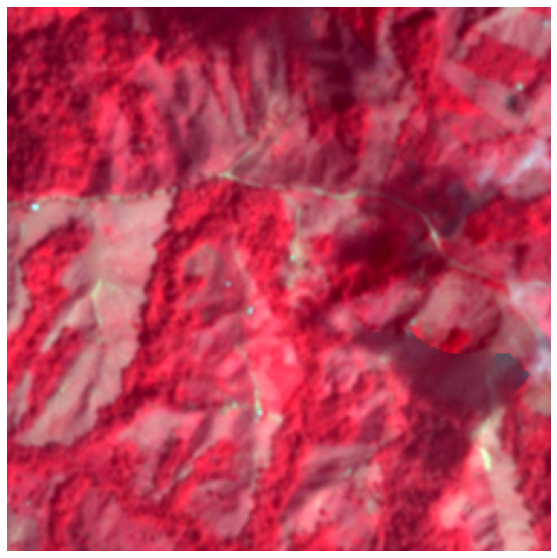

In [18]:
#check image from datablock
ctxs = tif_dls.show_batch(channels=(3,2,1), figsize=(10,10))


In [19]:
def _using_attr(f, attr, x):
    return f(getattr(x,attr))

In [20]:
def using_attr(f, attr):
    "Change function `f` to operate on `attr`"
    return partial(_using_attr, f, attr)

In [21]:
#define multichannel data loader

class MultiChannelImageDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, chans=None, extensions=['.tif'], 
                    train='train', valid='valid', valid_pct=None, seed=None, 
                    vocab=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from imagenet style dataset in `path` with `train`, `valid`, `test` subfolders (or provide `valid_pct`).
        Optionally list the channels to use."""
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           get_items=partial(get_files, extensions=extensions),
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func,chans=None, extensions=['.tif'], 
                       valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from list of `fnames` in `path`s with `label_func`.   
        Optionally list the channels to use."""

        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)
    
    @classmethod
    def from_name_func(cls, path, fnames, label_func, 
                       chans=None, extensions=['.tif'], **kwargs):
        """Create from name attrs in list of `fnames` in `path`s with `label_func`.
        Optionally list the channels to use."""
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, chans=chans, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, chans=None, extensions=['.tif'], **kwargs):
        """Create from list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use."""
        return cls.from_path_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, chans=None, extensions=['.tif'],**kwargs):
        """Create from name attrs in list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use"""
        return cls.from_name_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', chans=None, valid_pct=0.2, seed=None, 
                fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

    @classmethod
    def from_shapefile(cls, path, chans=None, shp_fname='labels.shp', **kwargs):
        """Create from shapefile `shp_fname` in `path` readable with geopandas.
        Optionally list the channels to use."""
        df = gpd.read_file(str(Path(path)/shp_fname))
        return cls.from_df(df, path=path, chans=chans, **kwargs)
    
    @classmethod
    def from_csv(cls, path,  chans=None, csv_fname='labels.csv', 
                 header='infer', delimiter=None, **kwargs):
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_lists(cls, path, fnames, labels,chans=None, valid_pct=0.2, 
                   seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   **kwargs):
        """Create from list of `fnames` in `path`. Specify dims to be either 2 (for 2d images) or 3 (for volumetric images)
        and optionally list the channels to use."""
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(dims=dims, chans=chans), y_block),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, (fnames, labels), path=path, **kwargs)
    
MultiChannelImageDataLoaders.from_csv = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_csv)
MultiChannelImageDataLoaders.from_shapefile = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_shapefile)
MultiChannelImageDataLoaders.from_name_func = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_name_func)
MultiChannelImageDataLoaders.from_path_re = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_path_re)
MultiChannelImageDataLoaders.from_name_re = delegates(to=MultiChannelImageDataLoaders.from_name_func)(MultiChannelImageDataLoaders.from_name_re)

In [22]:
#define method to get mask from the labels
def get_mask_from_tif(fn):
    return open_geotiff(fn, chans=[0])[0]

In [23]:
get_msk = lambda o: path_lbl/f'{o.stem}{o.suffix}'

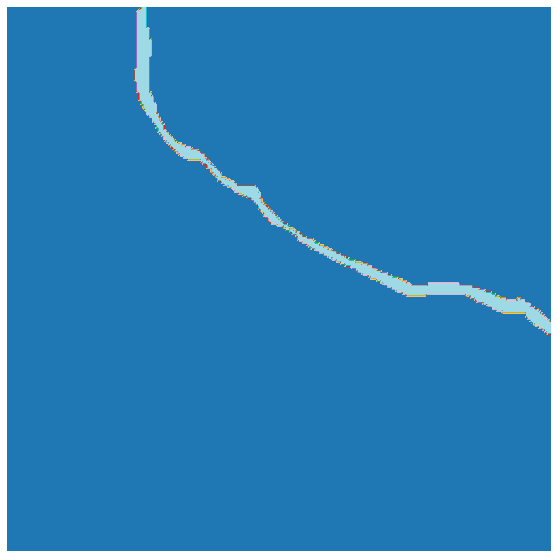

In [24]:
img_fn = '/content/PSCVPR_datasetV/labels/osa_105_12.tif'
msk = PILMask.create(get_mask_from_tif(img_fn))
msk.show(figsize=(10,10), alpha=1)

In [25]:
#define segmentation dataloaders incl. images and masks

#export
class TifSegmentationDataLoaders(DataLoaders):
    "Needs a better name"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_funcs(cls, path, fnames, label_func, chans=None, 
                         extensions=['.tif'], valid_pct=None, seed=None, 
                         codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), 
                                   MaskBlock(codes=codes)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [26]:
pathlist = Path('PSCVPR_datasetV')
pathlist.ls()

(#3) [Path('PSCVPR_datasetV/PS4B'),Path('PSCVPR_datasetV/codes.txt'),Path('PSCVPR_datasetV/labels')]

In [27]:
codes = np.loadtxt('/content/PSCVPR_datasetV/codes.txt', dtype=str); codes

array(['other', 'roads'], dtype='<U5')

In [28]:
batch_tfms = [Rotate(), Flip(), Dihedral()]

In [29]:
#testing valid dataset
segm = TifSegmentationDataLoaders.from_label_funcs(path='/content/PSCVPR_datasetV/PS4B/', 
                                                   bs=16, 
                                                   codes=codes,
                                                   fnames=get_files('/content/PSCVPR_datasetV/PS4B/', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/PSCVPR_datasetV/labels/{o.stem}{o.suffix}'),
                                                   valid_pct=0.05,
                                                   seed=42,
                                                   batch_tfms = batch_tfms)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [30]:
segm.valid_ds

(#35) [(MultiChannelTensorImage size=4x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=4x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=4x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=4x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=4x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=4x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=4x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=4x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=4x256x256, PILMask mode=F size=256x256),(MultiChannelTensorImage size=4x256x256, PILMask mode=F size=256x256)...]

In [31]:
segm.one_batch()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(MultiChannelTensorImage size=16x4x256x256,
 TensorMask([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 


In [32]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [33]:
cl = CombinedLoss()

In [34]:
learn =  unet_learner(segm, resnet34, n_in=4, metrics = [JaccardCoeff(), Dice()], loss_func=cl, opt_func=ranger, self_attention=True, pretrained=False, act_cls=Mish)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.00010964782268274575)

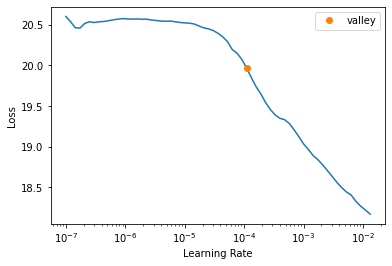

In [35]:
#find lr
learn.lr_find()

In [36]:
lr = 0.001

In [37]:
learn.fit_one_cycle(50, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,18.207777,15.242929,0.000000,0.000000,00:31
1,16.642956,14.972604,0.000323,0.000646,00:30
2,15.227021,13.229558,0.105161,0.190309,00:31
3,14.169845,12.364505,0.147865,0.257635,00:31
4,13.305165,11.879338,0.169871,0.290410,00:31
5,12.739849,11.599888,0.185600,0.313091,00:32
6,12.353225,11.377876,0.193252,0.323908,00:32
7,11.890572,10.918190,0.213433,0.351784,00:32
8,11.586254,10.743539,0.220530,0.361367,00:32
9,11.169560,10.496231,0.234906,0.380443,00:32


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [38]:
learn.save('after50')

Path('/content/PSCVPR_datasetV/PS4B/models/after50.pth')

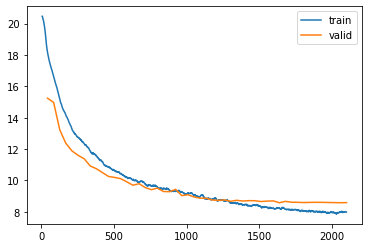

In [39]:
learn.recorder.plot_loss()

In [40]:
learn.unfreeze()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=7.585775892948732e-05)

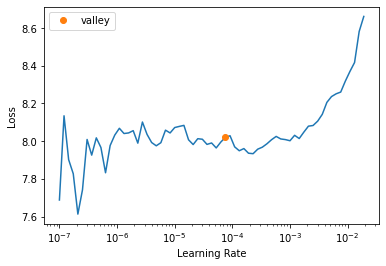

In [41]:
#find lr
learn.lr_find()

In [42]:
lr = 0.0001

In [43]:
learn.fit_flat_cos(30, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,7.957583,8.605832,0.309297,0.472463,00:31
1,7.984601,8.588087,0.309357,0.472532,00:32
2,7.955218,8.586858,0.310193,0.473508,00:32
3,7.950364,8.599023,0.309654,0.472879,00:32
4,7.973794,8.587224,0.311034,0.474487,00:32
5,7.987996,8.553455,0.311715,0.475278,00:32
6,7.930578,8.592007,0.307422,0.470272,00:32
7,7.909060,8.582834,0.310186,0.473500,00:33
8,7.973820,8.607297,0.309633,0.472855,00:32
9,7.924928,8.579078,0.310663,0.474055,00:33


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


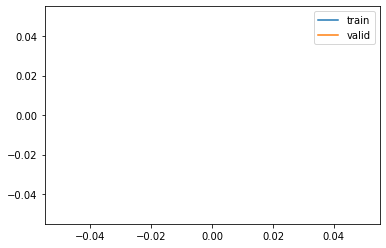

In [47]:
learn.recorder.plot_loss()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


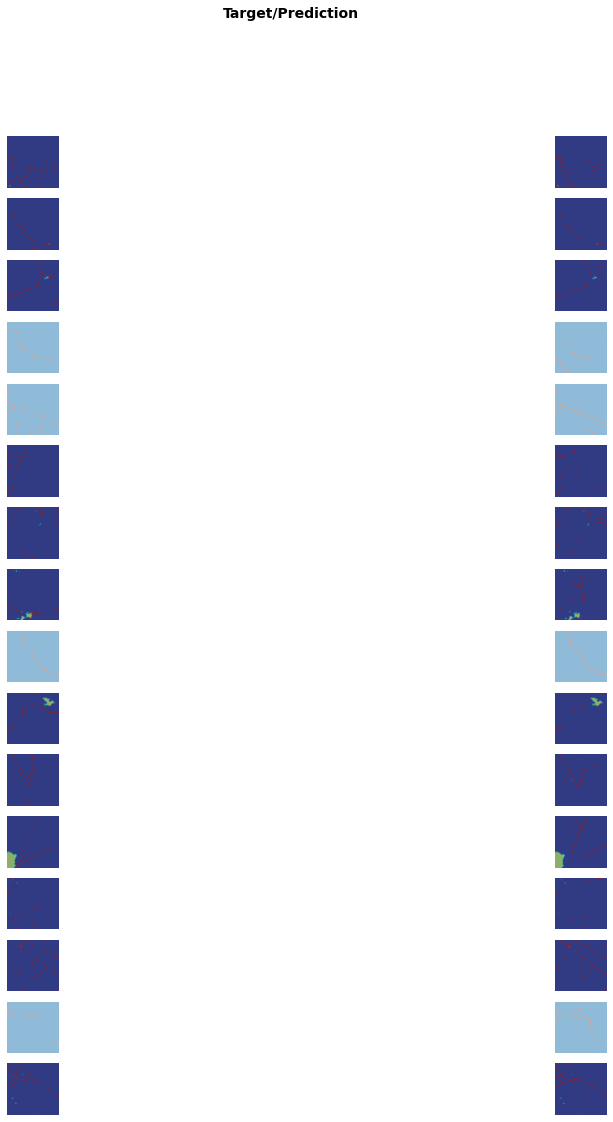

In [48]:
learn.show_results(max_n=20, figsize=(18,18))

In [49]:
learn.save('PS4B')

Path('/content/PSCVPR_datasetV/PS4B/models/PS4B.pth')

Inference

In [50]:
#Load datasets from Drive
!unzip /content/drive/MyDrive/Datasets/PD/ValidImagesPS.zip

Archive:  /content/drive/MyDrive/Datasets/PD/ValidImagesPS.zip
  inflating: ValidImagesPS/osa_106_0.tif  
  inflating: ValidImagesPS/osa_108_8.tif  
  inflating: ValidImagesPS/osa_109_12.tif  
  inflating: ValidImagesPS/osa_11_6.tif  
  inflating: ValidImagesPS/osa_127_14.tif  
  inflating: ValidImagesPS/osa_129_1.tif  
  inflating: ValidImagesPS/osa_13_9.tif  
  inflating: ValidImagesPS/osa_134_10.tif  
  inflating: ValidImagesPS/osa_14_10.tif  
  inflating: ValidImagesPS/osa_141_1.tif  
  inflating: ValidImagesPS/osa_141_6.tif  
  inflating: ValidImagesPS/osa_151_0.tif  
  inflating: ValidImagesPS/osa_151_5.tif  
  inflating: ValidImagesPS/osa_158_5.tif  
  inflating: ValidImagesPS/osa_159_10.tif  
  inflating: ValidImagesPS/osa_166_2.tif  
  inflating: ValidImagesPS/osa_168_14.tif  
  inflating: ValidImagesPS/osa_168_4.tif  
  inflating: ValidImagesPS/osa_169_6.tif  
  inflating: ValidImagesPS/osa_186_1.tif  
  inflating: ValidImagesPS/osa_190_15.tif  
  inflating: ValidImagesPS/osa

In [52]:
inferSet = [fn for fn in sorted((Path('/content/ValidImagesPS/')).glob('**/*')) if fn.is_file()]

In [53]:
inferSet[1].name

'osa_108_8.tif'

In [54]:
test_dl = learn.dls.test_dl(inferSet)

In [55]:
preds = learn.get_preds(dl=test_dl)

In [56]:
preds[0].shape

torch.Size([79, 2, 256, 256])

In [57]:
len(codes)

2

In [58]:
pred_1 = preds[0][0]

In [59]:
pred_1.shape

torch.Size([2, 256, 256])

In [60]:
pred_arx = pred_1.argmax(dim=0)

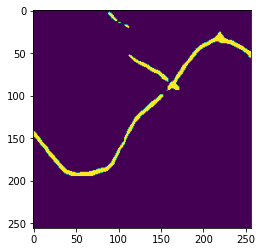

In [61]:
plt.imshow(pred_arx)

In [62]:
pred_arx = pred_arx.numpy()

In [63]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [64]:
im = Image.fromarray(rescaled)

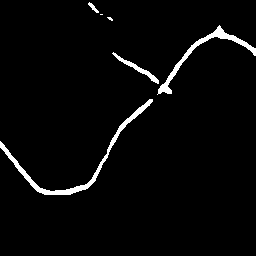

In [65]:
im

In [67]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(str(inferSet[i].name).split('/')[-1])
  # im.save(f'Image_{i}.png')

In [68]:
!mkdir PS_valid_res

In [69]:
!mv *.tif PS_valid_res/

In [70]:
!zip -r PS_valid_res.zip PS_valid_res/

  adding: PS_valid_res/ (stored 0%)
  adding: PS_valid_res/osa_109_11.tif (deflated 99%)
  adding: PS_valid_res/rp_673_5.tif (deflated 99%)
  adding: PS_valid_res/rp_713_13.tif (deflated 99%)
  adding: PS_valid_res/rp_448_10.tif (deflated 99%)
  adding: PS_valid_res/rp_831_12.tif (deflated 99%)
  adding: PS_valid_res/osa_44_8.tif (deflated 99%)
  adding: PS_valid_res/osa_151_5.tif (deflated 99%)
  adding: PS_valid_res/osa_55_12.tif (deflated 99%)
  adding: PS_valid_res/osa_106_0.tif (deflated 99%)
  adding: PS_valid_res/rp_171_15.tif (deflated 100%)
  adding: PS_valid_res/osa_20_10.tif (deflated 99%)
  adding: PS_valid_res/rp_142_7.tif (deflated 99%)
  adding: PS_valid_res/rp_107_12.tif (deflated 99%)
  adding: PS_valid_res/osa_109_12.tif (deflated 99%)
  adding: PS_valid_res/osa_63_8.tif (deflated 98%)
  adding: PS_valid_res/osa_190_6.tif (deflated 99%)
  adding: PS_valid_res/rp_106_1.tif (deflated 99%)
  adding: PS_valid_res/rp_712_11.tif (deflated 99%)
  adding: PS_valid_res/osa_20_

In [71]:
from google.colab import files
files.download("PS_valid_res.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## EXP1

In [ ]:
learn = unet_learner(segm, resnet34, n_in=4, pretrained=False)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn.summary()


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.00010964782268274575)

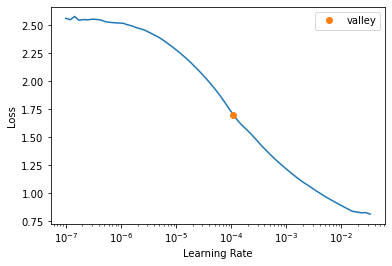

In [ ]:
#find lr
learn.lr_find()

In [ ]:
lr = 0.00010964782268274575

In [ ]:
learn.fit_one_cycle(20, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,0.125795,0.109972,00:26
1,0.102174,0.102184,00:25
2,0.095089,0.137188,00:25
3,0.089959,0.117030,00:25
4,0.086110,0.100470,00:25
5,0.082713,0.102783,00:25
6,0.075714,0.099007,00:25
7,0.075443,0.098122,00:25
8,0.075468,0.084896,00:25
9,0.069895,0.076415,00:25


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


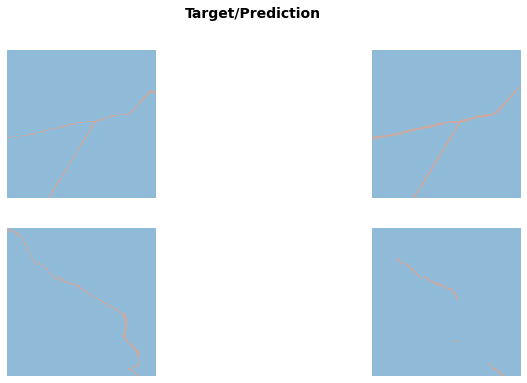

In [ ]:
learn.show_results(max_n=2, figsize=(12,6))

In [ ]:
learn.save('PSCVPR2')
learn.load('PSCVPR2');

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.00010964782268274575,
 slice(2.741195567068644e-07, 2.741195567068644e-05, None))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,time
0,0.045289,0.085698,00:25
1,0.044342,0.086061,00:25
2,0.044477,0.085558,00:25
3,0.044420,0.087025,00:25
4,0.044367,0.087913,00:25
5,0.043103,0.088926,00:25
6,0.043649,0.089462,00:25
7,0.045175,0.090278,00:25
8,0.042254,0.089477,00:25
9,0.042646,0.088347,00:25


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn.save('PSCVPR2')

Path('/content/PSCVPR_dataset/images/models/PSCVPR2.pth')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


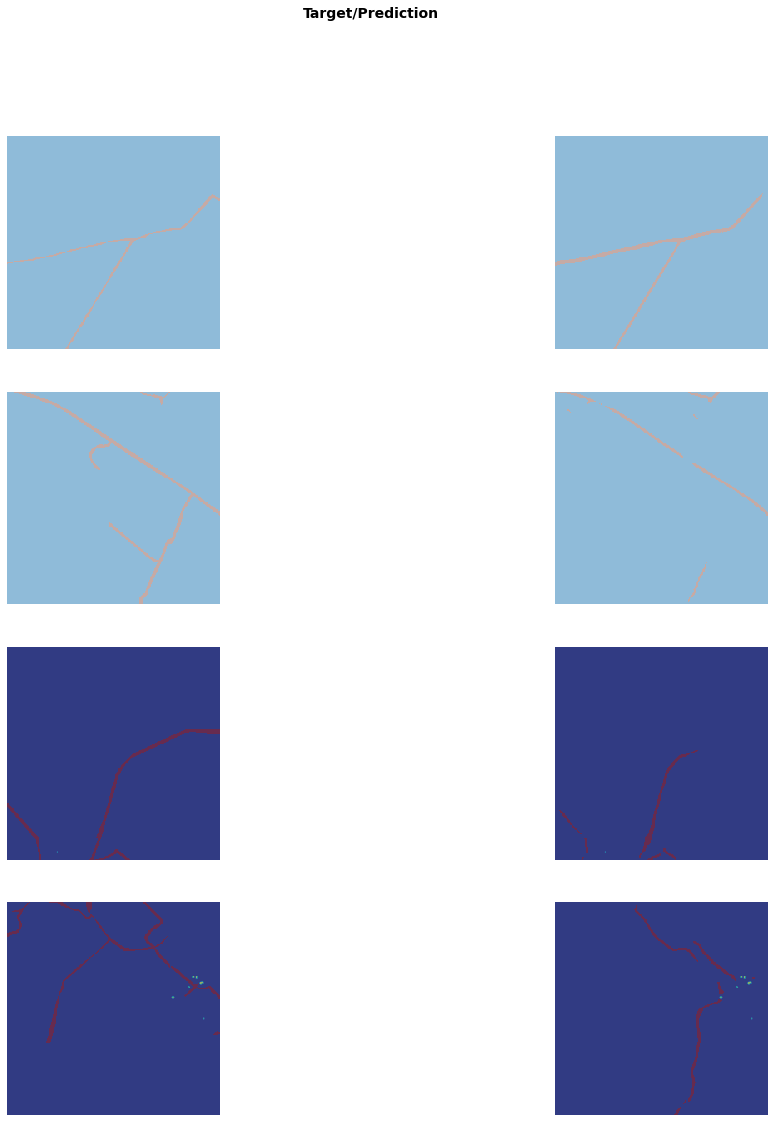

In [ ]:
learn.show_results(max_n=10, figsize=(18,18))

## EXP2


In [ ]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [ ]:
cl = CombinedLoss()

In [ ]:
learn2 = unet_learner(segm, resnet34, n_in=4, loss_func=cl, opt_func=ranger, pretrained=False)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0004786300996784121)

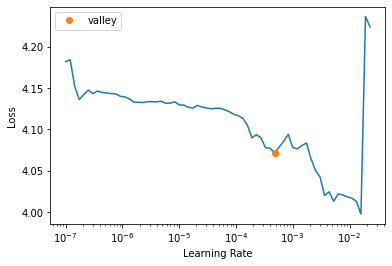

In [ ]:
#find lr
learn2.lr_find()

In [ ]:
lr = 0.0004786300996784121

In [ ]:
learn2.fit_flat_cos(20, slice(lr))

epoch,train_loss,valid_loss,time
0,3.374669,3.107208,00:23
1,3.144847,2.960776,00:23
2,2.957805,2.793197,00:23
3,2.855710,2.689086,00:24
4,2.717677,2.854364,00:23
5,2.682184,2.709160,00:23
6,2.544803,2.521200,00:23
7,2.490731,2.492735,00:23
8,2.436743,2.542591,00:23
9,2.343684,2.489628,00:23


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


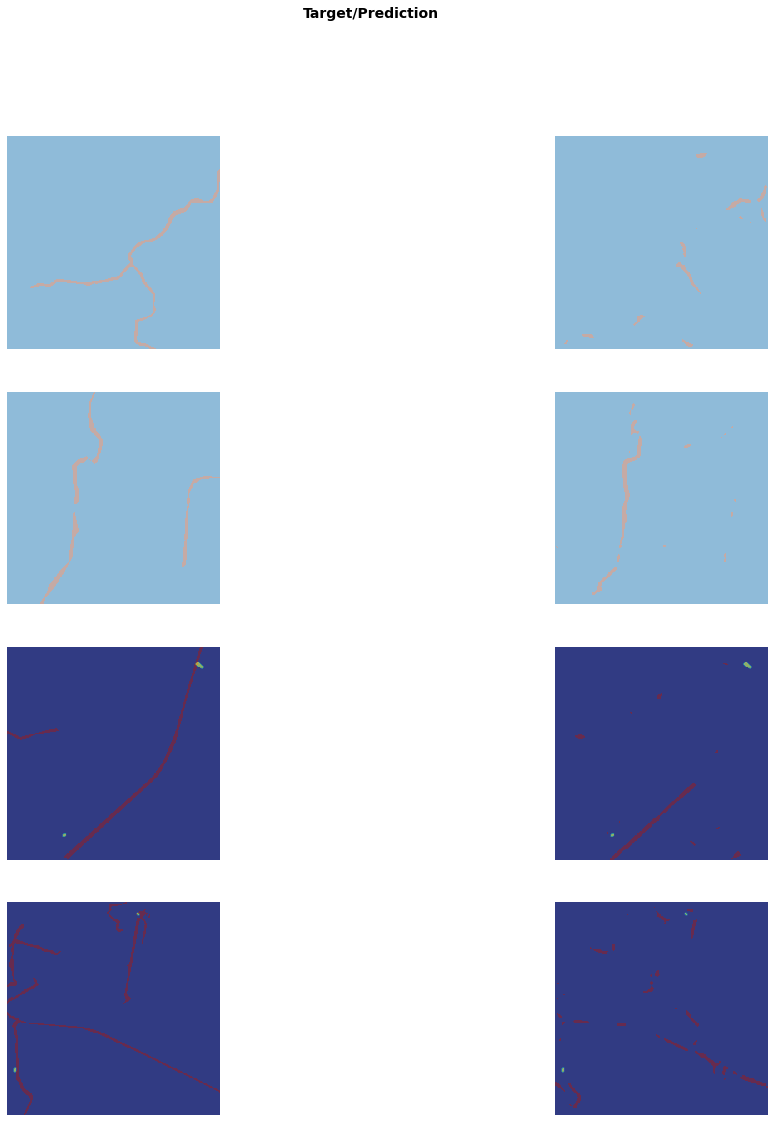

In [ ]:
learn2.show_results(max_n=10, figsize=(18,18))

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.0004786300996784121,
 slice(1.1965752491960301e-06, 0.00011965752491960302, None))

In [ ]:
learn.unfreeze()

In [ ]:
learn2.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,time
0,1.838557,2.567241,00:23
1,1.808394,2.528461,00:23
2,1.698168,2.521490,00:23
3,1.745685,2.510473,00:23
4,1.661457,2.578460,00:23
5,1.628961,2.527933,00:23
6,1.605363,2.663122,00:23
7,1.536119,2.582667,00:23
8,1.460944,2.581155,00:23
9,1.354461,2.591114,00:23


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


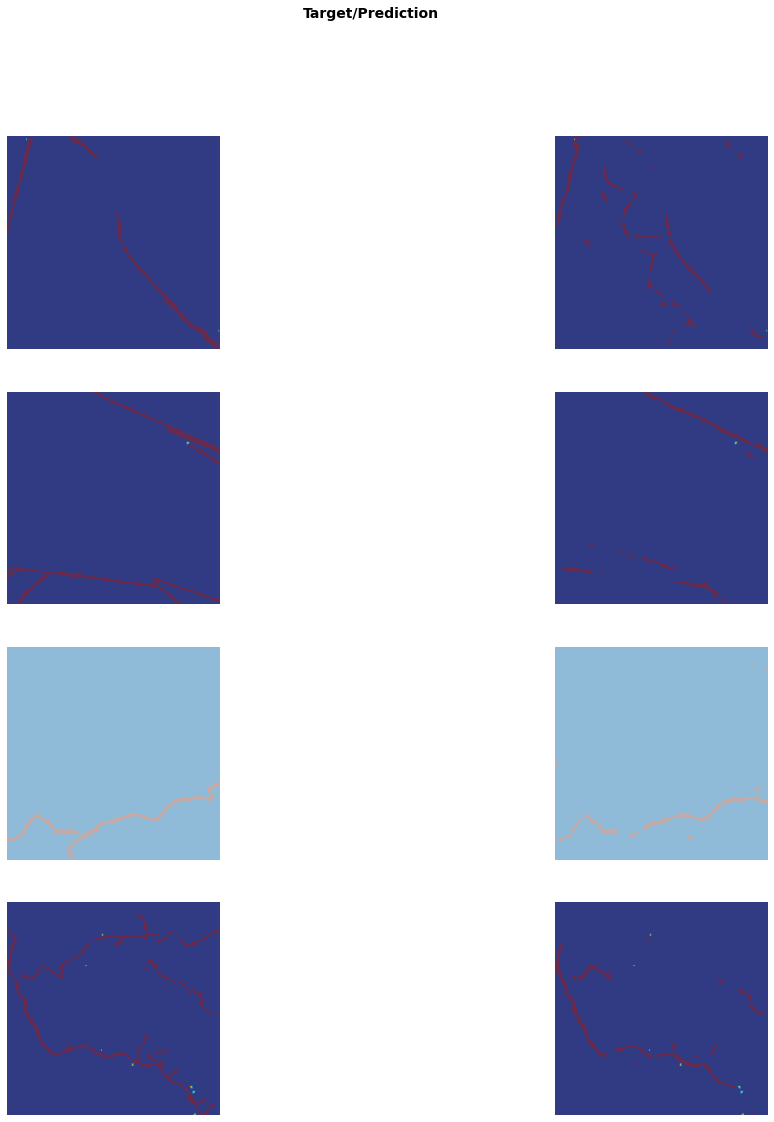

In [ ]:
learn2.show_results(max_n=10, figsize=(18,18))

## EXP3


Added data augmentation, and dice loss instead of combined loss

In [ ]:
segm3 = TifSegmentationDataLoaders.from_label_funcs(path='/content/PSCVPR_dataset/images/', 
                                                   bs=4, 
                                                   codes=codes,
                                                   fnames=get_files('/content/PSCVPR_dataset/images/', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/labelsFixedByte/{o.stem}{o.suffix}'),
                                                  #  batch_tfms=[*aug_transforms()],
                                                   splitter=FileSplitter(pathlist/'valid.txt'))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
dl = DiceLoss()

In [ ]:
lsce= LabelSmoothingCrossEntropy()

In [ ]:
learn3 = unet_learner(segm3, resnet34, n_in=4, loss_func=lsce, opt_func=ranger, metrics = [JaccardCoeff(), Dice()], pretrained=False)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn3 = unet_learner(segm3, resnet34, n_in=4, metrics = [JaccardCoeff(), Dice()], pretrained=False)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.00015848931798245758)

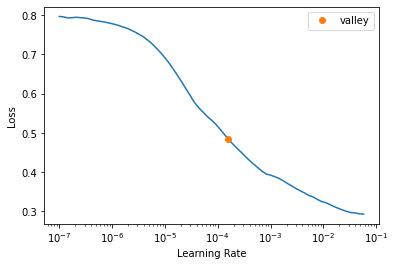

In [ ]:
#find lr
learn3.lr_find()

In [ ]:
lr = 0.00015848931798245758

In [ ]:
learn3.fit_one_cycle(10, slice(lr)) #with no aug

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,0.131103,0.113180,0.000508,0.001015,00:25
1,0.109471,0.104110,0.013718,0.027065,00:25
2,0.104071,0.096815,0.058826,0.111115,00:25
3,0.096003,0.094094,0.077459,0.143781,00:25
4,0.093513,0.092053,0.127734,0.226532,00:25
5,0.091210,0.094761,0.096579,0.176146,00:25
6,0.091259,0.088794,0.135231,0.238244,00:25
7,0.089135,0.088216,0.151012,0.262399,00:25
8,0.084531,0.087989,0.140150,0.245844,00:25
9,0.086671,0.087764,0.149874,0.260679,00:25


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.00015848931798245758,
 slice(3.9622329495614394e-07, 3.9622329495614395e-05, None))

In [ ]:
learn.unfreeze()

In [ ]:
learn3.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,0.086480,0.088749,0.176476,0.300008,00:25
1,0.085852,0.087723,0.154181,0.267170,00:25
2,0.086101,0.087748,0.176762,0.300421,00:25
3,0.084395,0.087595,0.137171,0.241250,00:25
4,0.084035,0.087754,0.148004,0.257845,00:25
5,0.082990,0.087941,0.175309,0.298319,00:25
6,0.081591,0.087530,0.169181,0.289401,00:25
7,0.080259,0.087171,0.170195,0.290883,00:25
8,0.081032,0.087217,0.175338,0.298362,00:25
9,0.080793,0.087394,0.170656,0.291556,00:25


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


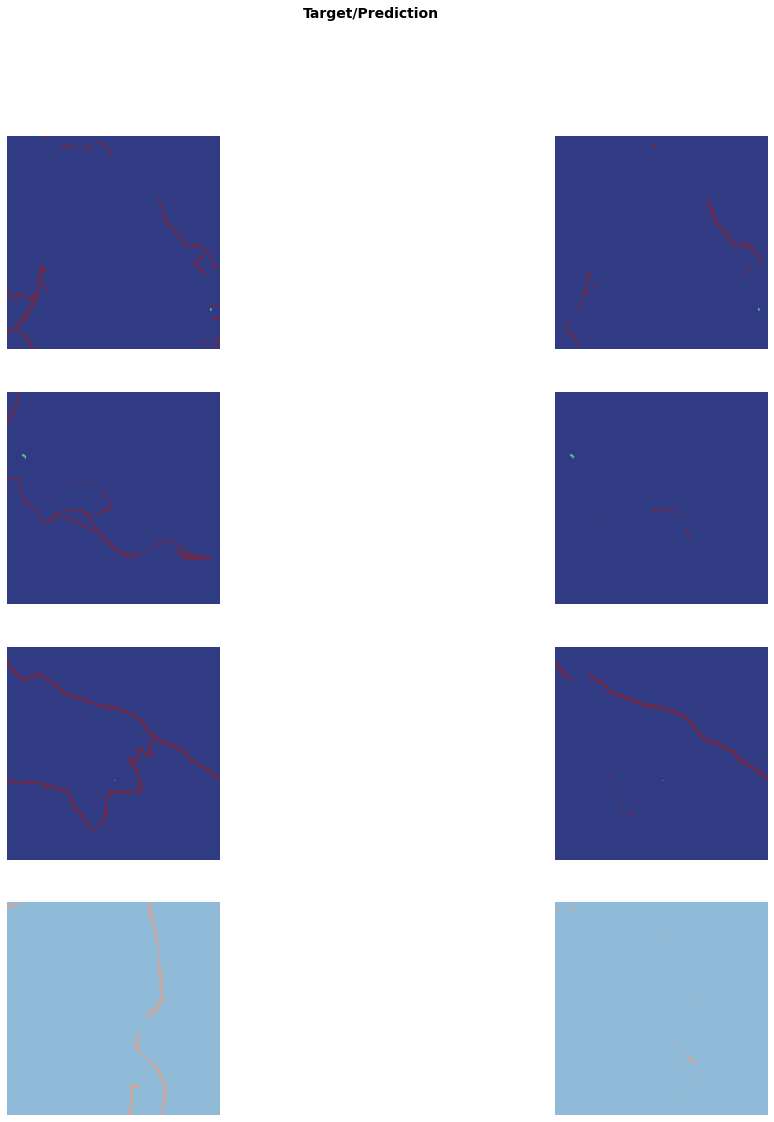

In [ ]:
learn3.show_results(max_n=10, figsize=(18,18))

In [ ]:
learn3.fit_one_cycle(10, slice(lr)) #with aug

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,0.133213,0.131910,0.000775,0.001549,00:25
1,0.105625,0.107701,0.014622,0.028823,00:25
2,0.099685,0.110830,0.022977,0.044922,00:25
3,0.096551,0.101679,0.054732,0.103783,00:25
4,0.094022,0.103843,0.089403,0.164131,00:26
5,0.092518,0.099658,0.093658,0.171274,00:25
6,0.088861,0.097919,0.095160,0.173782,00:25
7,0.087718,0.097860,0.085471,0.157482,00:25
8,0.086698,0.096316,0.092118,0.168696,00:25
9,0.087489,0.096400,0.102010,0.185134,00:25


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn3.fit_one_cycle(10, slice(lr), cbs=EarlyStoppingCallback(monitor='jaccard_coeff', min_delta=0.01, patience=3)) #this is with labelsmoothing, will try combined dice loss one more?

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,0.312738,0.274790,0.000290,0.000580,00:24
1,0.264821,0.263450,0.004027,0.008023,00:24
2,0.259632,0.259367,0.013129,0.025918,00:24
3,0.257592,0.257413,0.022597,0.044196,00:24
4,0.254269,0.256812,0.025605,0.049931,00:24
5,0.252161,0.255088,0.072517,0.135227,00:24
6,0.250685,0.253733,0.086446,0.159136,00:24
7,0.251198,0.253379,0.076962,0.142925,00:24
8,0.249754,0.253781,0.082347,0.152163,00:24
9,0.250104,0.253361,0.096499,0.176013,00:24


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


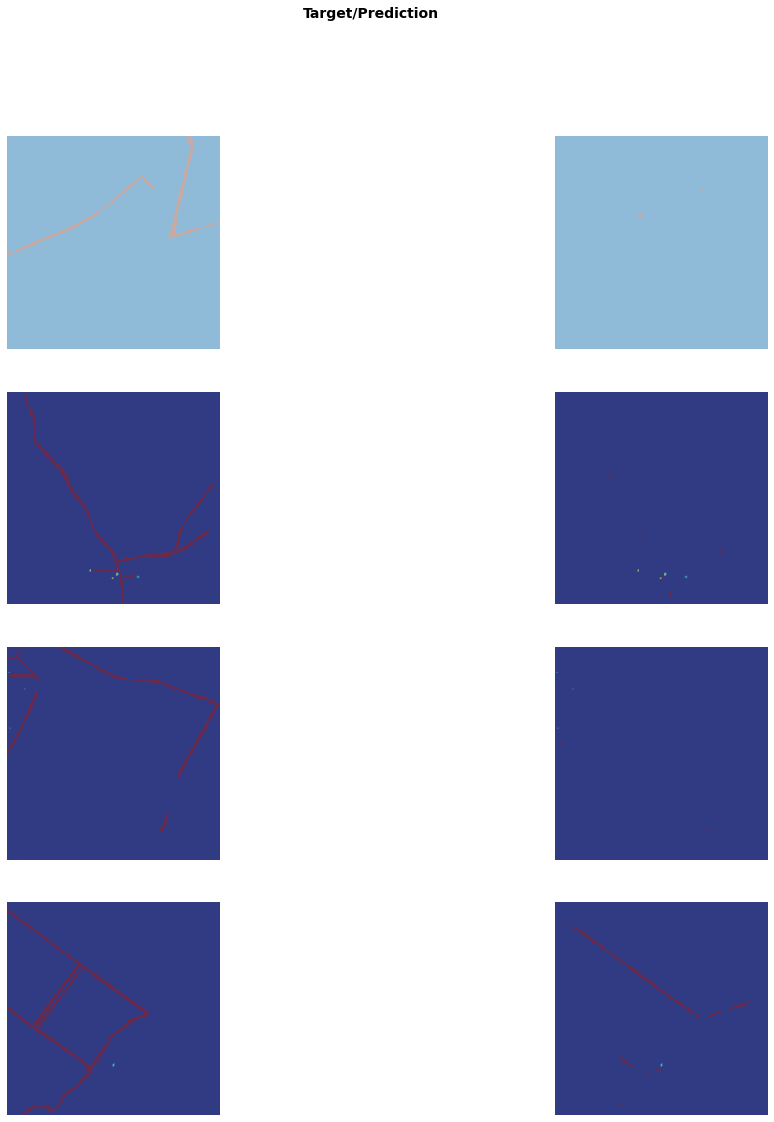

In [ ]:
learn3.show_results(max_n=10, figsize=(18,18))

In [ ]:
learn3.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,time
0,0.306898,0.277321,0.003992,00:24
1,0.264382,0.266257,0.002593,00:23
2,0.259926,0.260001,0.033592,00:23
3,0.258183,0.258177,0.041566,00:23
4,0.255010,0.256384,0.040006,00:23
5,0.252779,0.254579,0.073583,00:23
6,0.252191,0.256195,0.107849,00:23
7,0.250002,0.254245,0.088500,00:23
8,0.249260,0.253155,0.092025,00:23
9,0.251014,0.253568,0.091639,00:23


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


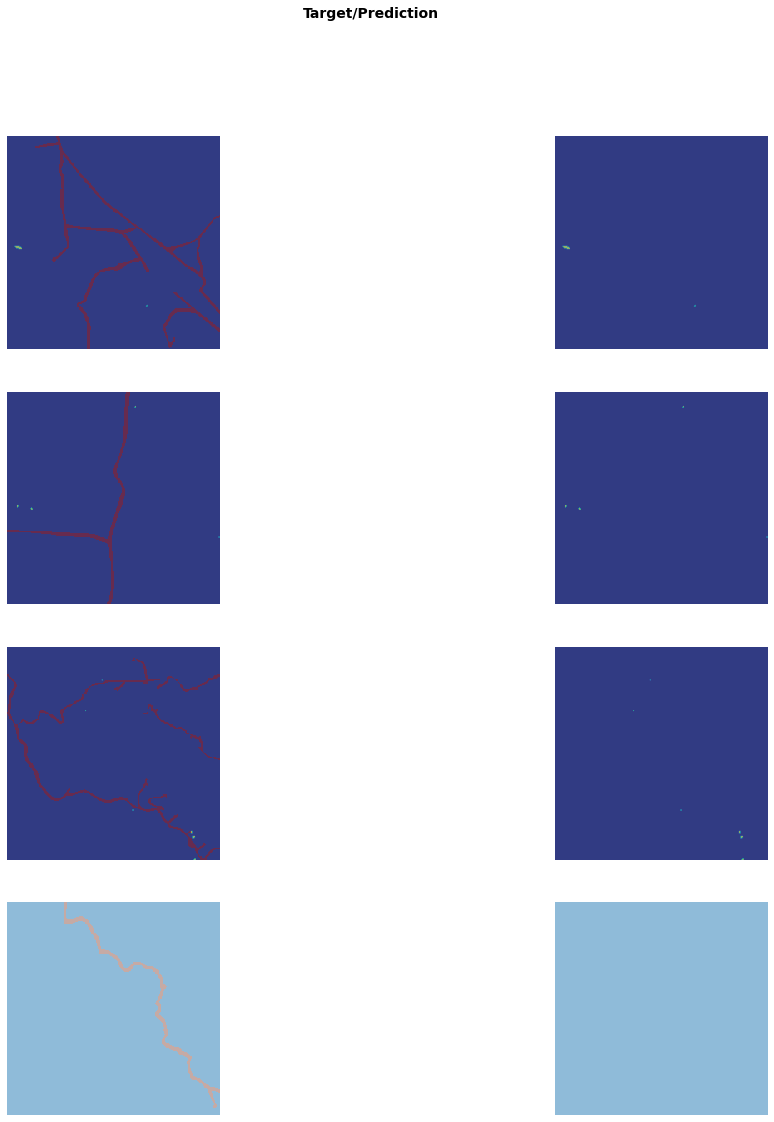

In [ ]:
learn3.show_results(max_n=10, figsize=(18,18))

## EXP Round 4


In [ ]:
segm4 = TifSegmentationDataLoaders.from_label_funcs(path='/content/PSCVPR_dataset/images/', 
                                                   bs=16, 
                                                   codes=codes,
                                                   fnames=get_files('/content/PSCVPR_dataset/images/', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/labelsFixedByte/{o.stem}{o.suffix}'),
                                                  #  batch_tfms=[*aug_transforms()],
                                                   splitter=FileSplitter(pathlist/'valid.txt'))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
segm4.one_batch()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(MultiChannelTensorImage size=16x4x256x256,
 TensorMask([[[0, 0, 0,  ..., 0, 1, 1],
          [0, 0, 0,  ..., 0, 1, 1],
          [0, 0, 0,  ..., 0, 0, 1],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 


In [ ]:
learn4 = unet_learner(segm4, resnet18, n_in=4, metrics = [JaccardCoeff(), Dice()], pretrained=False)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.00013182566908653826)

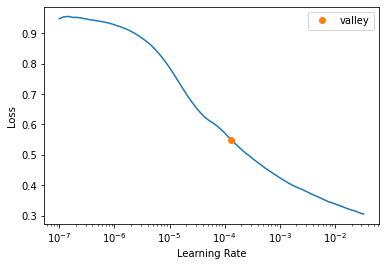

In [ ]:
#find lr
learn4.lr_find()

In [ ]:
lr = 0.00013182566908653826

In [ ]:
learn4.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,0.295900,0.195764,0.000011,0.000022,00:18
1,0.186720,0.134855,0.000000,0.000000,00:18
2,0.143716,0.111782,0.005730,0.011396,00:18
3,0.124245,0.103245,0.026856,0.052307,00:18
4,0.114167,0.101558,0.024805,0.048410,00:18
5,0.107706,0.098291,0.036485,0.070402,00:18
6,0.103312,0.096865,0.057178,0.108172,00:18
7,0.099873,0.095866,0.049694,0.094683,00:18
8,0.097451,0.094201,0.065308,0.122608,00:18
9,0.094794,0.095176,0.096128,0.175395,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.00013182566908653826,
 slice(3.2956417271634565e-07, 3.2956417271634564e-05, None))

In [ ]:
learn4.unfreeze()

In [ ]:
learn4.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,0.073214,0.107985,0.121060,0.215974,00:18
1,0.073414,0.102850,0.149627,0.260305,00:18
2,0.073818,0.107346,0.099229,0.180542,00:18
3,0.073247,0.107199,0.136537,0.240268,00:18
4,0.072134,0.104219,0.160214,0.276180,00:18
5,0.071520,0.105101,0.146724,0.255900,00:18
6,0.069660,0.108522,0.152707,0.264954,00:18
7,0.068643,0.109025,0.145242,0.253644,00:18
8,0.068556,0.112624,0.137017,0.241011,00:18
9,0.068555,0.110335,0.146595,0.255705,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


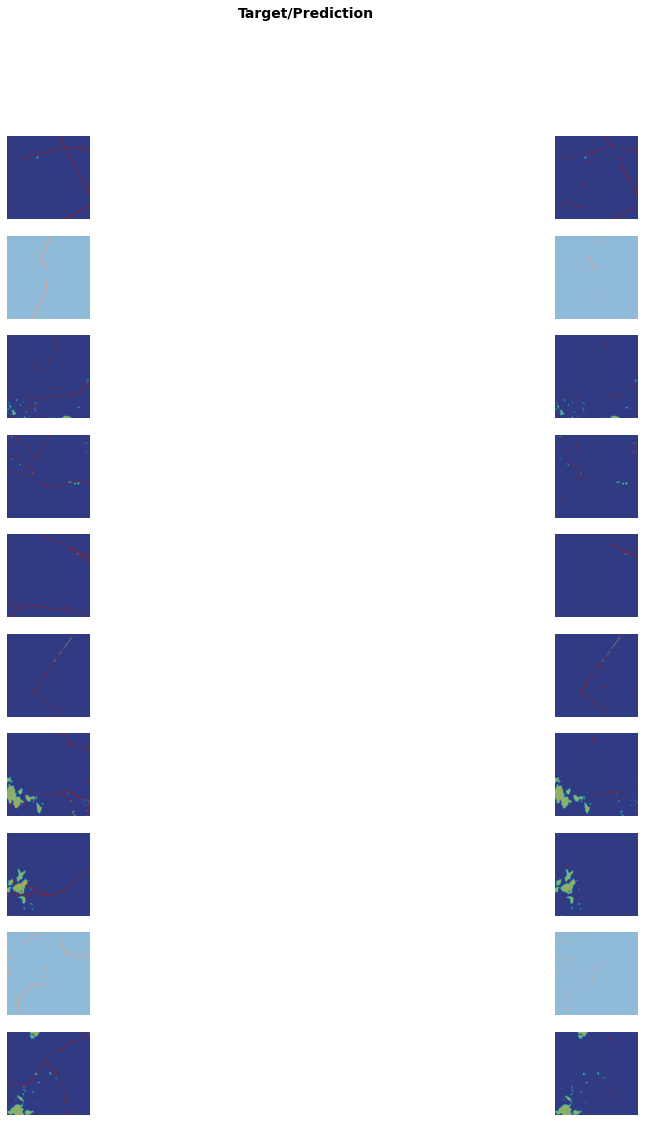

In [ ]:
learn4.show_results(max_n=10, figsize=(18,18))

## EXP 5 with resnet34

In [ ]:
learn5 = unet_learner(segm4, resnet34, n_in=4, metrics = [JaccardCoeff(), Dice()], loss_func=cl, opt_func=ranger, pretrained=False)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.002511886414140463)

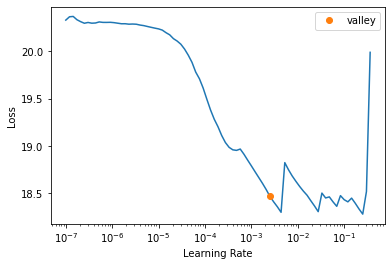

In [ ]:
#find lr
learn5.lr_find()

In [ ]:
lr = 0.0010000000474974513

In [ ]:
learn5.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,17.554724,16.182816,0.000004,0.000007,00:18
1,16.462154,15.997937,0.000262,0.000524,00:17
2,14.847239,13.076756,0.133511,0.235571,00:17
3,13.509055,12.001717,0.177278,0.301166,00:17
4,12.637995,12.163023,0.171389,0.292625,00:17
5,12.005725,11.098212,0.215853,0.355064,00:17
6,11.458719,10.806208,0.229435,0.373236,00:17
7,10.951450,10.301248,0.253088,0.403943,00:17
8,10.462936,10.100883,0.262261,0.415542,00:17
9,10.116321,9.924533,0.269464,0.424532,00:17


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.0010000000474974513,
 slice(2.5000001187436284e-06, 0.0002500000118743628, None))

In [ ]:
learn5.unfreeze()

In [ ]:
learn5.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,7.069441,10.008131,0.266988,0.421454,00:17
1,7.039714,10.073133,0.264057,0.417793,00:17
2,7.075613,10.051756,0.266250,0.420533,00:17
3,7.017538,9.933555,0.270006,0.425205,00:17
4,6.891058,10.140156,0.260279,0.413049,00:17
5,6.796279,10.120321,0.261466,0.414542,00:17
6,6.703903,10.108640,0.261886,0.415071,00:17
7,6.545296,10.136541,0.259860,0.412522,00:17
8,6.437179,10.155788,0.258860,0.411261,00:17
9,6.372210,10.175622,0.257996,0.410170,00:17


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


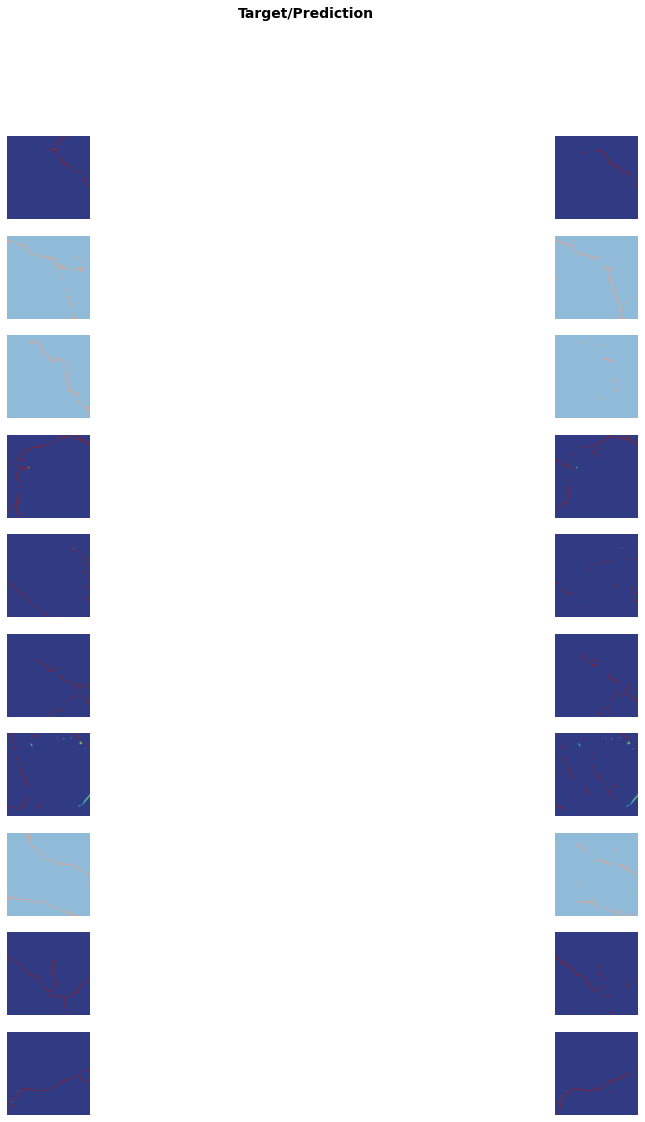

In [ ]:
learn5.show_results(max_n=10, figsize=(18,18))

## Experiment Round 6
applying batch transforms

In [ ]:
batch_tfms = [Rotate(), Flip(), Dihedral()]

In [ ]:
segm6 = TifSegmentationDataLoaders.from_label_funcs(path='/content/PSCVPR_dataset/images/', 
                                                   bs=16, 
                                                   codes=codes,
                                                   fnames=get_files('/content/PSCVPR_dataset/images/', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/labelsFixedByte/{o.stem}{o.suffix}'),
                                                   batch_tfms= batch_tfms,
                                                   splitter=FileSplitter(pathlist/'valid.txt'))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6 = unet_learner(segm6, resnet34, n_in=4, metrics = [JaccardCoeff(), Dice()], loss_func=cl, opt_func=ranger, self_attention=True, pretrained=False)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.00010964782268274575)

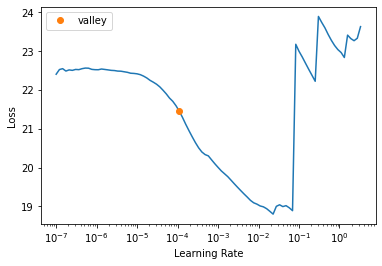

In [ ]:
#find lr
learn6.lr_find()

In [ ]:
lr = 0.00010964782268274575

In [ ]:
learn6.fit_one_cycle(20, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,21.473579,20.313328,0.019909,0.039040,00:18
1,18.546667,16.053932,0.000000,0.000000,00:18
2,17.120356,15.679682,0.019482,0.038220,00:18
3,15.853301,14.048806,0.093318,0.170706,00:18
4,14.764976,13.360546,0.116300,0.208367,00:18
5,13.900939,12.859771,0.139154,0.244311,00:18
6,13.366021,12.794123,0.149689,0.260399,00:18
7,12.944815,12.402559,0.154438,0.267555,00:18
8,12.705750,12.285742,0.163471,0.281006,00:18
9,12.462171,12.123288,0.164953,0.283193,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.00010964782268274575,
 slice(2.741195567068644e-07, 2.741195567068644e-05, None))

In [ ]:
learn6.unfreeze()

In [ ]:
learn6.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,11.788205,11.676595,0.186928,0.314977,00:18
1,11.749758,11.662874,0.185665,0.313183,00:18
2,11.741370,11.629291,0.188023,0.316531,00:18
3,11.753509,11.630624,0.187785,0.316194,00:18
4,11.764998,11.756850,0.186011,0.313675,00:18
5,11.728683,11.594090,0.189397,0.318475,00:18
6,11.697310,11.658183,0.189042,0.317973,00:18
7,11.680161,11.572667,0.191051,0.320810,00:18
8,11.633661,11.572372,0.191431,0.321346,00:18
9,11.606494,11.565619,0.190987,0.320720,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.fit_one_cycle(30, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,11.662724,11.597389,0.192427,0.322749,00:18
1,11.628066,11.529071,0.193386,0.324097,00:18
2,11.704671,11.544924,0.190105,0.319476,00:18
3,11.733887,11.750466,0.186942,0.314997,00:18
4,11.795472,11.421016,0.196459,0.328400,00:18
5,11.695614,11.331114,0.201863,0.335916,00:18
6,11.644339,11.584750,0.187650,0.316002,00:18
7,11.569405,11.539862,0.199576,0.332744,00:18
8,11.450649,11.358254,0.199331,0.332404,00:18
9,11.370042,11.004606,0.216949,0.356545,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.save('isthisitQ')

Path('/content/PSCVPR_dataset/images/models/isthisitQ.pth')

In [ ]:
learn6.fit_one_cycle(20, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,10.298634,10.233612,0.254212,0.405373,00:18
1,10.304216,10.247126,0.253259,0.404161,00:18
2,10.291316,10.343707,0.250952,0.401217,00:18
3,10.400064,10.192986,0.256813,0.408673,00:18
4,10.454493,10.372856,0.246468,0.395466,00:18
5,10.429989,10.183376,0.256266,0.407980,00:18
6,10.397326,10.211074,0.255775,0.407358,00:18
7,10.331656,10.178252,0.256183,0.407875,00:18
8,10.360377,10.298182,0.252558,0.403267,00:18
9,10.276316,10.084927,0.261131,0.414122,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.fit_one_cycle(20, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,9.825937,9.942829,0.269084,0.424061,00:19
1,9.862466,10.000844,0.266139,0.420395,00:18
2,9.924124,10.032874,0.262923,0.416372,00:18
3,9.950848,9.950945,0.269237,0.424251,00:18
4,10.087078,10.174382,0.257354,0.409358,00:18
5,10.080865,10.075338,0.263202,0.416723,00:18
6,10.030681,10.134572,0.257941,0.410100,00:18
7,9.971382,9.908677,0.269462,0.424530,00:18
8,10.005733,10.121027,0.260377,0.413173,00:18
9,9.941646,9.844037,0.273219,0.429178,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.save('isthisitQ2')

Path('/content/PSCVPR_dataset/images/models/isthisitQ2.pth')

In [ ]:
learn6.fit_one_cycle(20, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,9.489348,9.817388,0.274429,0.430669,00:18
1,9.599222,9.774420,0.276118,0.432747,00:18
2,9.633029,9.831790,0.275442,0.431916,00:18
3,9.666053,9.787348,0.275868,0.432439,00:18
4,9.736520,9.888846,0.271241,0.426734,00:18
5,9.745229,9.787514,0.275918,0.432501,00:18
6,9.836364,10.025901,0.265874,0.420064,00:18
7,9.821395,9.838632,0.272354,0.428111,00:18
8,9.756927,9.825083,0.274723,0.431032,00:18
9,9.726330,9.739367,0.278311,0.435436,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.save('isthisitQ3')

In [ ]:
learn6.fit_one_cycle(20, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,9.303015,9.680799,0.281796,0.439690,00:18
1,9.305505,9.659403,0.282202,0.440183,00:18
2,9.384189,9.848186,0.274414,0.430651,00:18
3,9.478971,9.798887,0.274945,0.431305,00:18
4,9.437290,9.663194,0.278170,0.435263,00:18
5,9.520410,9.728460,0.277225,0.434105,00:18
6,9.578555,9.734914,0.275019,0.431396,00:18
7,9.537480,9.641637,0.280572,0.438198,00:18
8,9.503657,9.689179,0.278923,0.436185,00:18
9,9.429981,9.720469,0.279462,0.436843,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.save('isthisitQ4')

Path('/content/PSCVPR_dataset/images/models/isthisitQ4.pth')

In [ ]:
learn6.fit_one_cycle(20, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,9.034416,9.651004,0.282585,0.440650,00:18
1,9.032615,9.598137,0.284504,0.442978,00:18
2,9.120448,9.876244,0.272864,0.428740,00:18
3,9.269363,9.641526,0.280881,0.438575,00:18
4,9.296075,9.707903,0.279685,0.437116,00:18
5,9.293028,9.684944,0.278901,0.436158,00:18
6,9.226326,9.710166,0.277728,0.434722,00:18
7,9.231112,9.605864,0.283126,0.441307,00:18
8,9.276970,9.636818,0.282966,0.441112,00:18
9,9.208224,9.560549,0.286185,0.445014,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.save('isthisitQ5')

Path('/content/PSCVPR_dataset/images/models/isthisitQ5.pth')

In [ ]:
learn6.fit_one_cycle(20, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,8.787078,9.539039,0.287809,0.446974,00:18
1,8.840350,9.575362,0.284110,0.442501,00:18
2,8.874714,9.642131,0.282117,0.440080,00:18
3,9.013919,9.614718,0.281665,0.439530,00:18
4,9.075606,9.679993,0.280070,0.437586,00:18
5,9.108382,9.539634,0.286208,0.445041,00:18
6,9.037237,9.776285,0.276423,0.433121,00:18
7,9.080291,9.494556,0.289938,0.449538,00:18
8,9.023431,9.628035,0.282360,0.440375,00:18
9,9.010331,9.551249,0.286424,0.445302,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.save('isthisitQ6')

Path('/content/PSCVPR_dataset/images/models/isthisitQ6.pth')

In [ ]:
learn6.fit_one_cycle(20, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,8.683452,9.508030,0.288712,0.448063,00:18
1,8.707463,9.510659,0.289267,0.448731,00:18
2,8.750316,9.707804,0.278113,0.435193,00:18
3,8.880025,9.534196,0.285959,0.444741,00:18
4,8.905393,9.627506,0.281950,0.439877,00:18
5,8.907968,9.478042,0.287967,0.447165,00:18
6,8.891701,9.710765,0.278770,0.435997,00:18
7,8.877378,9.481578,0.289543,0.449063,00:18
8,8.898021,9.464942,0.291280,0.451150,00:18
9,8.852377,9.508450,0.287593,0.446715,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.save('isthisitQ7')

Path('/content/PSCVPR_dataset/images/models/isthisitQ7.pth')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=7.585775892948732e-05)

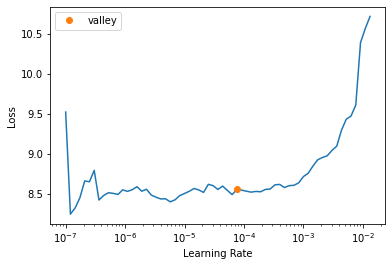

In [ ]:
learn6.lr_find()

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.0010000000474974513,
 slice(2.5000001187436284e-06, 0.0002500000118743628, None))

In [ ]:
learn6.fit_one_cycle(20, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,8.391347,9.488326,0.289249,0.448710,00:18
1,8.487554,9.507193,0.289049,0.448468,00:18
2,8.564899,9.578132,0.285056,0.443647,00:18
3,8.650860,9.494503,0.289140,0.448578,00:18
4,8.669645,9.618630,0.281298,0.439083,00:18
5,8.791155,9.410102,0.292748,0.452908,00:18
6,8.737686,9.589695,0.281602,0.439453,00:18
7,8.744751,9.540101,0.285793,0.444539,00:18
8,8.738792,9.548316,0.283336,0.441561,00:18
9,8.720963,9.471890,0.290858,0.450643,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.save('isthisitQ8')

Path('/content/PSCVPR_dataset/images/models/isthisitQ8.pth')

In [ ]:
learn6.load('isthisitQ8')

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0002290867705596611)

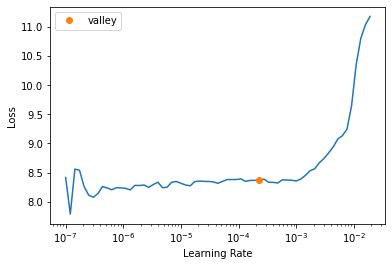

In [ ]:
learn6.lr_find()

In [ ]:
lr = 0.0002290867705596611

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.0002290867705596611,
 slice(5.727169263991528e-07, 5.727169263991527e-05, None))

In [ ]:
learn6.fit_flat_cos(20, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,8.470746,9.473084,0.290532,0.450252,00:18
1,8.526042,9.475301,0.291008,0.450823,00:18
2,8.505250,9.511086,0.288038,0.447250,00:18
3,8.506619,9.490419,0.289598,0.449129,00:18
4,8.467123,9.505777,0.288205,0.447452,00:18
5,8.497558,9.479888,0.289131,0.448567,00:18
6,8.468405,9.474964,0.290587,0.450318,00:18
7,8.485362,9.555975,0.284936,0.443503,00:18
8,8.476650,9.455078,0.290114,0.449749,00:18
9,8.489038,9.408323,0.292165,0.452209,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.00015848931798245758)

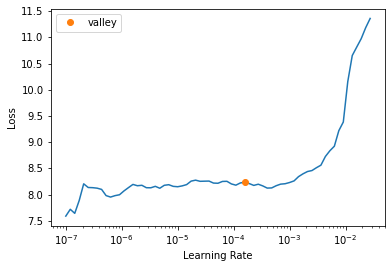

In [ ]:
learn6.lr_find()

In [ ]:
lr = 0.00015848931798245758

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.00015848931798245758,
 slice(3.9622329495614394e-07, 3.9622329495614395e-05, None))

In [ ]:
learn6.fit_flat_cos(50, slice(lr))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,8.254848,9.488109,0.287324,0.446390,00:19
1,8.267619,9.394857,0.292016,0.452032,00:18
2,8.300724,9.499783,0.287656,0.446791,00:18
3,8.262280,9.442246,0.288952,0.448352,00:18
4,8.294890,9.435856,0.290130,0.449768,00:18
5,8.298862,9.384376,0.293092,0.453320,00:18
6,8.244082,9.432938,0.289584,0.449113,00:18
7,8.224969,9.421185,0.290234,0.449893,00:18
8,8.130106,9.431365,0.291757,0.451721,00:18
9,8.203916,9.388626,0.291872,0.451859,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.fit_flat_cos(50, slice(4.365158383734524e-05))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,7.747830,9.373382,0.292552,0.452673,00:18
1,7.667564,9.352539,0.292893,0.453081,00:18
2,7.602798,9.367596,0.291967,0.451973,00:18
3,7.681724,9.413420,0.289701,0.449252,00:18
4,7.684875,9.374352,0.291105,0.450939,00:18
5,7.608123,9.358400,0.292248,0.452310,00:18
6,7.656868,9.351288,0.293235,0.453490,00:18
7,7.618831,9.338445,0.293486,0.453791,00:18
8,7.657105,9.378212,0.291443,0.451344,00:18
9,7.647847,9.335879,0.294926,0.455511,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


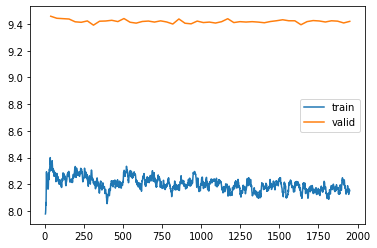

In [ ]:
learn6.recorder.plot_loss()

In [ ]:
learn6.fit_one_cycle(50, lrs)

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,8.367109,9.447534,0.290966,0.450773,00:18
1,8.354402,9.455768,0.290610,0.450346,00:18
2,8.324784,9.449882,0.290552,0.450275,00:18
3,8.297070,9.446892,0.291493,0.451405,00:18
4,8.306951,9.447570,0.290775,0.450543,00:18
5,8.294725,9.454350,0.290569,0.450296,00:18
6,8.313348,9.448407,0.291068,0.450895,00:18
7,8.309926,9.455773,0.290472,0.450179,00:18
8,8.314726,9.445424,0.290862,0.450648,00:18
9,8.331948,9.460957,0.290493,0.450205,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=3.311311274956097e-06)

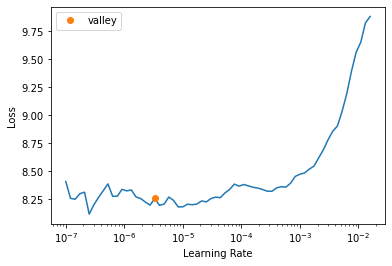

In [ ]:
learn6.lr_find()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


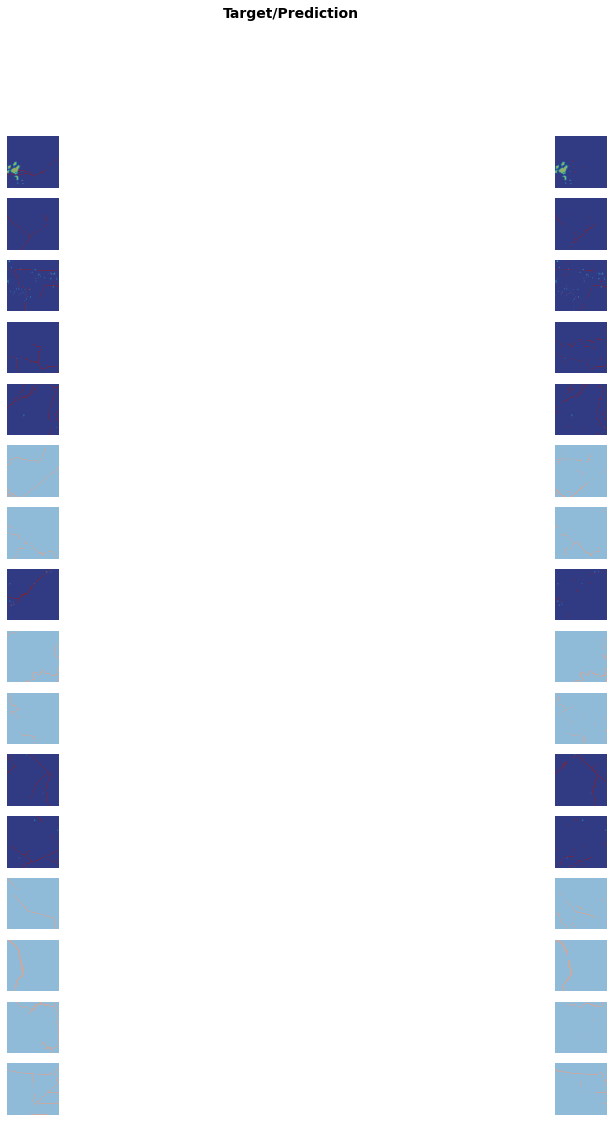

In [ ]:
learn6.show_results(max_n=20, figsize=(18,18))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


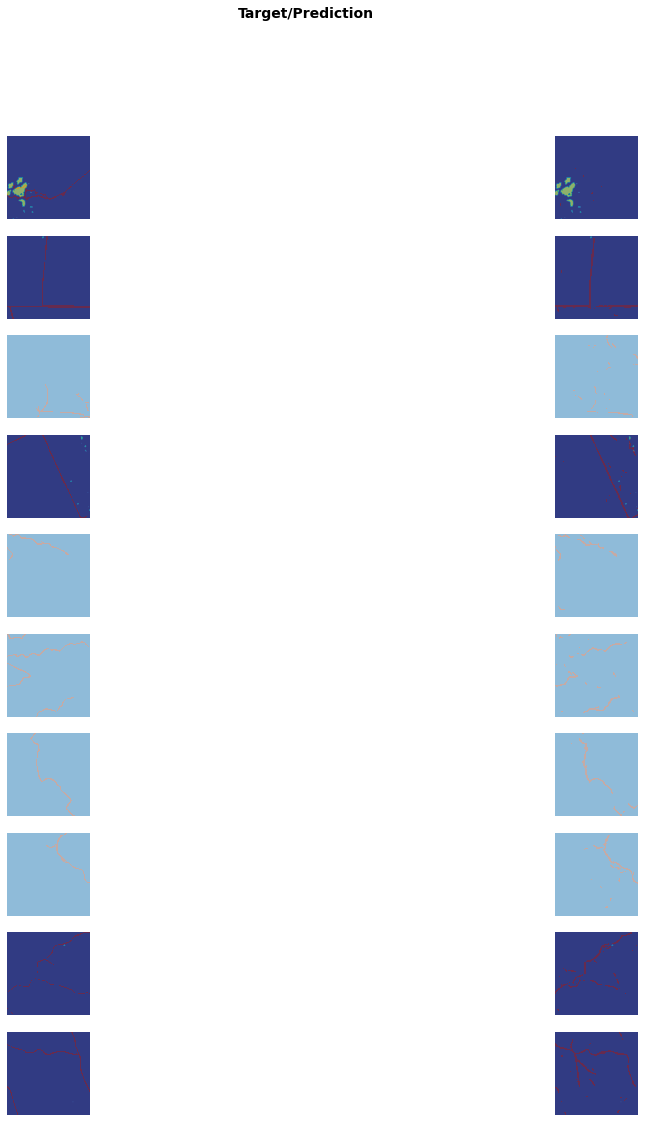

In [ ]:
learn6.show_results(max_n=10, figsize=(18,18))

In [ ]:
learn6.save('overtrained')

Path('/content/PSCVPR_dataset/images/models/overtrained.pth')

In [ ]:
learn6.load('isthisitQ8')

In [ ]:
learn6.show_results(max_n=10, figsize=(18,18))

ValueError: ignored

In [ ]:
learn6.fit_flat_cos(50, slice(3.311311274956097e-06))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,8.347582,9.457614,0.289914,0.449509,00:18
1,8.258847,9.442436,0.291070,0.450897,00:18
2,8.244489,9.439622,0.291090,0.450922,00:18
3,8.288090,9.436814,0.291079,0.450908,00:18
4,8.324867,9.415988,0.291949,0.451952,00:18
5,8.306190,9.412333,0.292188,0.452237,00:18
6,8.240155,9.422669,0.291288,0.451159,00:18
7,8.218391,9.390922,0.293079,0.453305,00:18
8,8.133812,9.420453,0.291284,0.451154,00:18
9,8.162393,9.422003,0.291151,0.450994,00:18


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn6.export(os.path.abspath('./PSCVPR.pkl'))

PicklingError: ignored

In [ ]:
learn6

In [ ]:
!-type f -name '*.pth

/bin/bash: -y: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


In [ ]:
interp = SegmentationInterpretation.from_learner(learn6)
interp.plot_top_losses(9)

/usr/local/lib/python3.7/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


TypeError: ignored

In [ ]:
learn6.recorder.plot_losses()

AttributeError: ignored

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarnin

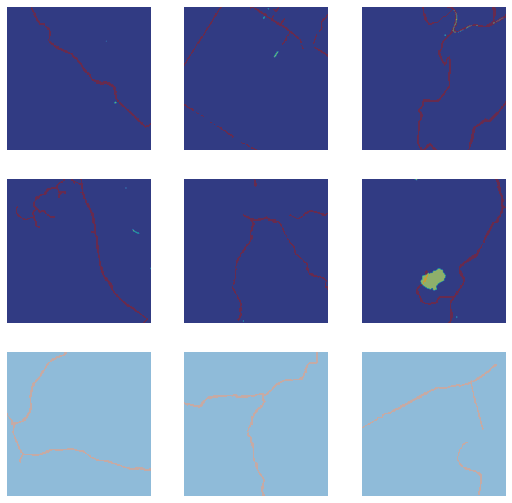

In [ ]:
segm6.show_batch()

In [ ]:
dl = learn6.dls.valid

In [ ]:
test = learn6.dls.valid_ds

In [ ]:
len(test)

158

In [ ]:
preds = learn.get_preds(dl=dl)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
preds[0].shape

torch.Size([158, 2, 256, 256])

In [ ]:
len(codes)

2

In [ ]:
pred_1 = preds[0][0]

In [ ]:
pred_1.shape

torch.Size([2, 256, 256])

In [ ]:
pred_arx = pred_1.argmax(dim=0)

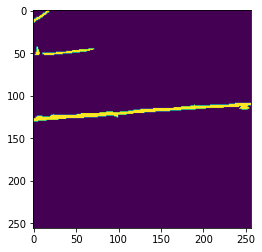

In [ ]:
plt.imshow(pred_arx)

In [ ]:
pred_arx = pred_arx.numpy()

In [ ]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [ ]:
im = Image.fromarray(rescaled)

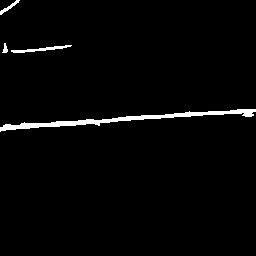

In [ ]:
im

In [ ]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(str(learn6.dls.valid_ds.items[i]).split('/')[-1])
  # im.save(f'Image_{i}.png')

In [ ]:
!mkdir PS_res1

In [ ]:
!mv *.tif PS_res1/

In [ ]:
!zip -r PS_res1.zip PS_res1/

  adding: PS_res1/ (stored 0%)
  adding: PS_res1/rp_168_7.tif (deflated 98%)
  adding: PS_res1/rp_192_3.tif (deflated 99%)
  adding: PS_res1/rp_218_5.tif (deflated 99%)
  adding: PS_res1/rp_165_2.tif (deflated 99%)
  adding: PS_res1/rp_416_13.tif (deflated 99%)
  adding: PS_res1/osa_109_1.tif (deflated 99%)
  adding: PS_res1/rp_164_13.tif (deflated 98%)
  adding: PS_res1/rp_320_13.tif (deflated 99%)
  adding: PS_res1/osa_175_12.tif (deflated 99%)
  adding: PS_res1/osa_216_5.tif (deflated 99%)
  adding: PS_res1/osa_28_5.tif (deflated 99%)
  adding: PS_res1/osa_217_3.tif (deflated 98%)
  adding: PS_res1/osa_143_13.tif (deflated 99%)
  adding: PS_res1/osa_169_3.tif (deflated 99%)
  adding: PS_res1/rp_798_5.tif (deflated 99%)
  adding: PS_res1/osa_13_3.tif (deflated 98%)
  adding: PS_res1/osa_41_2.tif (deflated 99%)
  adding: PS_res1/rp_162_15.tif (deflated 98%)
  adding: PS_res1/rp_706_2.tif (deflated 99%)
  adding: PS_res1/osa_109_9.tif (deflated 99%)
  adding: PS_res1/rp_163_3.tif (defl

In [ ]:
from google.colab import files
files.download("PS_res1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>